# Ciência dos Dados - Projeto 03 - 

$Arthur\space Alegro \space de \space Oliveira$

$Pedro\space dos\space Santos \space e \space Silva$

$Jhonata\space Ferreira\space de \space Souza$

# 1. Introdução

## Importando Bibliotecas:

In [1]:
% matplotlib inline
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import random
import os

## Base de Dados:

Base de dados do ENEM referente aos anos de 2015 e 2016 extraídas pelo site http://portal.inep.gov.br/microdados.

Nomes dos arquivos:
* MICRODADOS_ENEM_2015.csv
* MICRODADOS_ENEM_2016.csv

**OBS.:** Para rodar corretamente este arquivo arquivo iPython Notebook (`.ipynb`)  deve-se extrair o arquivo `.zip` correspondente, acessar a pasta "DADOS" e colocar os arquivos `.csv` citados anteriormente no mesmo diretório deste arquivo.


## Diretório:

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\duals\Documents\GitHub\CDDP_final


#### Link para a base de dados já filtrada:
https://drive.google.com/open?id=1yq4DAJyJ2Er902X7Z1JuGc_t7w-aTIXJ

# 2. Minerando Dados e Características do Dataset

## Verificando dimensões dos arquivos:

In [2]:
def thousand_dot(number):
    """Convert int value in a string with dots as thousands separator"""
    lista = []
    count = 0
    for digit in (str(number))[::-1]:
        lista.append(digit)
        count +=1
        if count == 3:
            lista.append('.')
            count = 0
    lista.reverse
    elements = ''.join(lista)[::-1]
    return elements


def dimension_calculator(filename, chunksize=1000, sep=','):
    """Counts the amount of rows and columns on a .csv file"""
    # Raising warning:
    warnings.warn("\n\nWARNING! Depending on chunksize value and/or file size this process might take time to compute")
    # Parameters:
    rows = 0
    columns_labels = ''
    count = True
    # Process progress exibited to user:
    print("Processing...")
    # Opening database and counting values:
    for chunk in pd.read_csv(filename, chunksize=chunksize, encoding='latin-1', header=0, sep=sep):
        rows += len(chunk['NU_INSCRICAO'])
        if count == True:
            columns_labels = chunk.columns.values
            count = False
            
    # Process progress exibited to user:
    print("Process complete\n")   
    print("Number of rows: {}".format(thousand_dot(rows)))
    print("Number of columns: {}".format(len(columns_labels)))
    print("Number of elements: {}".format(thousand_dot(rows*len(columns_labels))))

* **2015**

In [4]:
dimension_calculator("MICRODADOS_ENEM_2015.csv")

C:\Users\duals\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: 

WARNING! Depending on chunksize value and/or file size this process might take time to compute


Processing...
Process complete

Number of rows: 7.746.427
Number of columns: 166
Number of elements: 1.285.906.882


* **2016**

In [5]:
dimension_calculator("MICRODADOS_ENEM_2016.csv", sep=';')

Processing...


C:\Users\duals\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: 

WARNING! Depending on chunksize value and/or file size this process might take time to compute


Process complete

Number of rows: 8.627.367
Number of columns: 166
Number of elements: 1.432.142.922


## Filtragem do Database:

Selecionamos uma parte da base de dados (100.000 rows de dados) para análise em escala reduzida.

Após todas as filtragens e cálculos forem concluídos, todo o processo será refeito para cada `chunk`, podendo aplicar as implementações para todo a base de dados muito mais rápido, sem a necessidade de carregar o arquivo completo de uma vez (o que pode ser impossível, pois, em alguns casos, demanda mais processamento e memória que o computador possui)

In [3]:
def save_df(to_open_filename, database_year,iteration_times, chunksize=1000, sep=','):
    # Raising warning:
    warnings.warn("\n\nWARNING! Depending on chunksize value and/or file size this process might take time to compute")

    # Counters and Status Controllers:
    overallcounter = 0
    chunkcounter = 0
    filecounter = 0
    shapecounter = [0, 0]
    to_save_filename = "filtered_dataframe_{}({}).csv".format(database_year, filecounter)
    # Process progress exibited to user:
    print("Opening file...")
    # Loading database in chunks and defining chunk size, correct enconding and reading configs:
    for chunk in pd.read_csv(to_open_filename, chunksize=chunksize, encoding='latin-1', header=0, sep=sep):

        # Selecting relevant parameters for dismiss useless data:
        chunk = chunk[(chunk["TP_PRESENCA_CN"] == 1) & (chunk["TP_PRESENCA_CH"] == 1) & 
                      (chunk["TP_PRESENCA_LC"] == 1) & (chunk["TP_PRESENCA_MT"] == 1) & 
                      (chunk["TP_STATUS_REDACAO"] == 1) & (chunk["IN_TREINEIRO"] == 0)]

        # Selecting relevant parameters for fitering data:
        chunk = chunk.loc[:, ["SG_UF_RESIDENCIA", "NU_IDADE", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA", "TP_ST_CONCLUSAO", 
                              "TP_ESCOLA", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO", "Q006"]]

        # Exporting dataframe to new .csv file below existent data:
        chunk.to_csv(to_save_filename, index=False)

        # Counters update and process progress exibited to user:
        chunkcounter += 1
        overallcounter += 1
        filecounter += 1
        shapecounter[0] += chunk.shape[0]
        shapecounter[1] = chunk.shape[1]
        print("Processing... ({}/{}) - {} rows processed - Saving in '{}')".format(overallcounter, iteration_times, shapecounter[0], to_save_filename))
        to_save_filename = "filtered_dataframe_{}({}).csv".format(database_year, filecounter)
    print("Process Completed")

* **2015**

In [5]:
# Creating filtered .csv file:
save_df('MICRODADOS_ENEM_2015.csv', database_year=2015, chunksize=1000000, iteration_times=8)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: 

WARNING! Depending on chunksize value and/or file size this process might take time to compute
  app.launch_new_instance()


Opening file...
Processing... (1/8) - 723612 rows processed - Saving in 'filtered_dataframe_2015(0).csv')
Processing... (2/8) - 1425321 rows processed - Saving in 'filtered_dataframe_2015(1).csv')
Processing... (3/8) - 2097387 rows processed - Saving in 'filtered_dataframe_2015(2).csv')
Processing... (4/8) - 2742262 rows processed - Saving in 'filtered_dataframe_2015(3).csv')
Processing... (5/8) - 3346414 rows processed - Saving in 'filtered_dataframe_2015(4).csv')
Processing... (6/8) - 3928083 rows processed - Saving in 'filtered_dataframe_2015(5).csv')
Processing... (7/8) - 4429373 rows processed - Saving in 'filtered_dataframe_2015(6).csv')
Processing... (8/8) - 4768463 rows processed - Saving in 'filtered_dataframe_2015(7).csv')
Process Completed


* **2016**

In [6]:
# Creating filtered .csv file:
save_df('MICRODADOS_ENEM_2016.csv', database_year=2016, chunksize=1000000, iteration_times=9, sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: 

WARNING! Depending on chunksize value and/or file size this process might take time to compute
  app.launch_new_instance()


Opening file...
Processing... (1/9) - 658887 rows processed - Saving in 'filtered_dataframe_2016(0).csv')
Processing... (2/9) - 1309576 rows processed - Saving in 'filtered_dataframe_2016(1).csv')
Processing... (3/9) - 1932155 rows processed - Saving in 'filtered_dataframe_2016(2).csv')
Processing... (4/9) - 2540238 rows processed - Saving in 'filtered_dataframe_2016(3).csv')
Processing... (5/9) - 3116716 rows processed - Saving in 'filtered_dataframe_2016(4).csv')
Processing... (6/9) - 3656028 rows processed - Saving in 'filtered_dataframe_2016(5).csv')
Processing... (7/9) - 4154448 rows processed - Saving in 'filtered_dataframe_2016(6).csv')
Processing... (8/9) - 4604923 rows processed - Saving in 'filtered_dataframe_2016(7).csv')
Processing... (9/9) - 4868906 rows processed - Saving in 'filtered_dataframe_2016(8).csv')
Process Completed


## Verificando integridade dos arquivos:

In [7]:
filename_list_2015 = ["filtered_dataframe_2015(0).csv", "filtered_dataframe_2015(1).csv", 
                      "filtered_dataframe_2015(2).csv", "filtered_dataframe_2015(3).csv", 
                      "filtered_dataframe_2015(4).csv", "filtered_dataframe_2015(5).csv", 
                      "filtered_dataframe_2015(6).csv", "filtered_dataframe_2015(7).csv"]

filename_list_2016 = ["filtered_dataframe_2016(0).csv", "filtered_dataframe_2016(1).csv",
                      "filtered_dataframe_2016(2).csv", "filtered_dataframe_2016(3).csv", 
                      "filtered_dataframe_2016(4).csv", "filtered_dataframe_2016(5).csv", 
                      "filtered_dataframe_2016(6).csv", "filtered_dataframe_2016(7).csv", 
                      "filtered_dataframe_2016(8).csv"]

In [8]:
def integrity_verification(filename_list, database_year):
    """Counts the amount of rows in multiple .csv files"""
    # Raising warning:
    warnings.warn("\n\nWARNING! Depending on files amount and/or files size this process might take time to compute")
    rows_count = 0
    for filename in filename_list:
        for chunk in pd.read_csv(filename, chunksize=1000, encoding='latin-1', header=0, sep=','):
            rows_count += chunk.shape[0]
    print("{} database - Total rows: {}".format(database_year, rows_count))

In [9]:
integrity_verification(filename_list_2015, 2015)
integrity_verification(filename_list_2016, 2016)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: 

WARNING! Depending on files amount and/or files size this process might take time to compute


2015 database - Total rows: 4768463
2016 database - Total rows: 4868906


In [10]:
def merge_multifiles(filename_list, database_year):
    """Merging all data to unique filtered file"""
    # Raising warning:
    warnings.warn("\n\nWARNING! Depending on chunksize value, files amount and/or files size this process might take time to compute")

    print("Process iniciated...")
    #
    chunk_list = []
    
    print("Processing...")
    
    for filename in filename_list:
            for chunk in pd.read_csv(filename, chunksize=10000, encoding='latin-1', header=0, sep=','):
                chunk_list.append(chunk)
                
    print("Merging all data...")
    final_df = pd.concat(chunk_list)
    
    print("Exporting data...")
    final_df.to_csv("filtered_unique_database_{}.csv".format(database_year), index=False)
    print("Process complete")

In [11]:
merge_multifiles(filename_list_2015, 2015)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: 

WARNING! Depending on chunksize value, files amount and/or files size this process might take time to compute


Process iniciated...
Processing...
Merging all data...
Exporting data...
Process complete


In [12]:
merge_multifiles(filename_list_2016, 2016)

Process iniciated...
Processing...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: 

WARNING! Depending on chunksize value, files amount and/or files size this process might take time to compute


Merging all data...
Exporting data...
Process complete


## Separando Bases (teste e treinamento):

In [16]:
def database_separation(filename_list, database_year, display_step=10, sep=',', chunksize=1000):
    """Generates random sample for training and test databases and exports to separated .csv files"""
    # Raising warning:
    warnings.warn("\n\nWARNING! Depending on chunksize value, files amount and/or files size this process might take time to compute")
    # Local data storages:
    training_df_list = []
    test_df_list = []
    # Counter:
    chunkcounter = 0
    # Process progress exibited to user:
    print("Process iniciated...")
    # Reading all data from filtered .csv files:
    for filename in filename_list:
        for chunk in pd.read_csv(filename, chunksize=chunksize, encoding='latin-1', header=0, sep=sep):
            # Creating list with chunk indexers:
            indexers = list(range(0, (chunksize + 1)))
            
            #
            chunk.reindex(indexers)
            
            # Random shuffling chunk's index values:
            random.shuffle(indexers)
            
            # Separating 80% to training database and 20% to test database:
            training_chunk_idx = indexers[:int((0.8)*chunksize)]
            test_chunk_idx = indexers[int((0.8)*chunksize):]

            # Sorting chunk indexers:
            training_chunk_idx.sort()
            test_chunk_idx.sort()
            
            # Slicing chunk's data:
            training_chunk = chunk.iloc[training_chunk_idx, :]
            test_chunk = chunk.iloc[test_chunk_idx, :]

            # Setting 'is_copy' argument (avoid file corruption):
            training_chunk.is_copy
            test_chunk.is_copy
            
            # Appending separated chunk data to reference DataFrame list:
            training_df_list.append(training_chunk)
            test_df_list.append(test_chunk)
            
            # Counters update and process progress exibited to user:
            chunkcounter += 1
            
            if chunkcounter%display_step == 0:
                print("{} chunks processed - {} rows processed".format(chunkcounter, chunkcounter*chunksize))
                
    # Process progress exibited to user:
    print("Meriging all data...")
    # Merging to unique dataframe:
    training_df = pd.concat(training_df_list, ignore_index=True)
    test_df = pd.concat(test_df_list, ignore_index=True)
    
    # Process progress exibited to user:
    print("Exporting data...")
    # Exporting DataFrames to separated .csv files:
    #training_df.to_csv("training_database_{}.csv".format(database_year), index=False)
    test_df.to_csv("test_database_{}.csv".format(database_year), index=False)
    
    # Process progress exibited to user:
    print("Process complete")

* **2015**

In [17]:
database_separation(filename_list_2015, 2015, chunksize=10000)

Process iniciated...


C:\Users\duals\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 

WARNING! Depending on chunksize value, files amount and/or files size this process might take time to compute
  after removing the cwd from sys.path.


IndexError: positional indexers are out-of-bounds

In [13]:
help(pd.DataFrame.reindex)

Help on function reindex in module pandas.core.frame:

reindex(self, labels=None, index=None, columns=None, axis=None, method=None, copy=True, level=None, fill_value=nan, limit=None, tolerance=None)
    Conform DataFrame to new index with optional filling logic, placing
    NA/NaN in locations having no value in the previous index. A new object
    is produced unless the new index is equivalent to the current one and
    copy=False
    
    Parameters
    ----------
    labels : array-like, optional
        New labels / index to conform the axis specified by 'axis' to.
    index, columns : array-like, optional (should be specified using keywords)
        New labels / index to conform to. Preferably an Index object to
        avoid duplicating data
    axis : int or str, optional
        Axis to target. Can be either the axis name ('index', 'columns')
        or number (0, 1).
    method : {None, 'backfill'/'bfill', 'pad'/'ffill', 'nearest'}, optional
        method to use for filling h

* **2016**

In [107]:
database_separation(filename_list_2016, 2016, chunksize=5000000)

C:\Users\duals\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 

WARNING! Depending on chunksize value, files amount and/or files size this process might take time to compute
  after removing the cwd from sys.path.


Process iniciated...
Meriging all data...
Exporting data...
Process complete


Nome das colunas:
* `SG_UF_RESIDENCIA`: Sigla da Unidade de Federação da residência do candidato
* `NU_IDADE`: Idade do candidato
* `TP_SEXO`: Sexo do candidato
* `TP_ESTADO_CIIVL`: Estado Civil do candidato
* `TP_COR_RACA`: Grupo étinco a qual o candidato se identifica
* `TP_ST_CONCLUSAO`: Situação de conclusão do Ensino Médio
* `TP_ESCOLA`: Tipo de escola do Ensino Médio
* `NU_NOTA`: Notas nas avaliações do ENEM, sendo:

|Sigla   |    Descrição        |
|--------|---------------------|
|CN      |Ciências da Natureza |
|CH      |Ciências Humanas     |
|LC      |Linguagens e Códigos |
|MT      |Matemática           |
|REDACAO |Redação              |
    
* `Q006`: Renda mensal da família

# Porquê essas colunas foram escolhidas?

- A Unidade de Federação é bem relevante no acesso à escolaridade, pois sabe-se que, no Brasil, educação de boa qualidade, de maneira geral, é acessada por meios privados. Sendo assim, há regiões que são pobres em desenvolvimento humano.
- Idade influencia, tendo em vista que um jovem de 17-20 anos tende a lembrar mais do conteudo ante a um adulto de 30+
- Grupo Étnico (vulgarmente conhecido como "Raça") tem grande peso na nota, tendo em vista o sistema de cotas
- Situação de conclusão do Ensino Médio diz, aproximadamente, se o candidato se encontra preparado para a prova, ou não
- Tipo de escola nos ajuda a montar o perfil do aluno, e  o que esperar do seu desempenho
- Nota da prova é útil para a análise pra estabelecer a base de treinamento

# Análise descritiva:

- Gráficos de como cada variável afeta na nota do candidato
    - Boxplot de renda com nota
    - Gráfico de barras para nota com outra variável qualitativa
    

In [11]:
data_2015 = pd.read_csv('filtered_unique_database_2015.csv', encoding='latin-1', header=0, sep=',')

data_2016 = pd.read_csv('filtered_unique_database_2016.csv', encoding='latin-1', header=0, sep=',')

In [5]:
data_2015.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q006
0,RS,42.0,M,1.0,1,1,1,657.4,705.3,591.1,732.3,760.0,D
1,PE,22.0,M,1.0,2,4,1,528.5,531.1,511.3,566.5,640.0,B
2,MG,18.0,M,0.0,3,1,1,679.9,730.6,621.2,732.4,800.0,G
3,SC,19.0,M,0.0,1,1,1,598.7,658.0,579.0,576.4,480.0,F
4,SP,17.0,F,0.0,1,2,2,652.1,671.9,609.3,685.5,820.0,J


Erro bosta que fudeu tudo que eu fiz

In [34]:
data_2015.NU_NOTA_CH.describe()

count    4.768463e+06
mean     5.606695e+02
std      7.000239e+01
min      0.000000e+00
25%      5.165000e+02
50%      5.661000e+02
75%      6.088000e+02
max      8.506000e+02
Name: NU_NOTA_CH, dtype: float64

In [35]:
data_2016.NU_NOTA_CH.describe()

count    4.868906e+06
mean     5.374636e+02
std      7.371680e+01
min      0.000000e+00
25%      4.883000e+02
50%      5.400000e+02
75%      5.884000e+02
max      8.591000e+02
Name: NU_NOTA_CH, dtype: float64

In [41]:
faixa = np.arange(0,900,50)

In [59]:
notacutCN = pd.cut(data_2015.NU_NOTA_CN, bins=faixa, right=False)
data_2015['FAIXA_CN'] = notacutCN

notacutCH = pd.cut(data_2015.NU_NOTA_CH, bins=faixa, right=False)
data_2015['FAIXA_CH'] = notacutCH

notacutLC = pd.cut(data_2015.NU_NOTA_LC, bins=faixa, right=False)
data_2015['FAIXA_LC'] = notacutLC

notacutMT = pd.cut(data_2015.NU_NOTA_MT, bins=faixa, right=False)
data_2015['FAIXA_MT'] = notacutMT

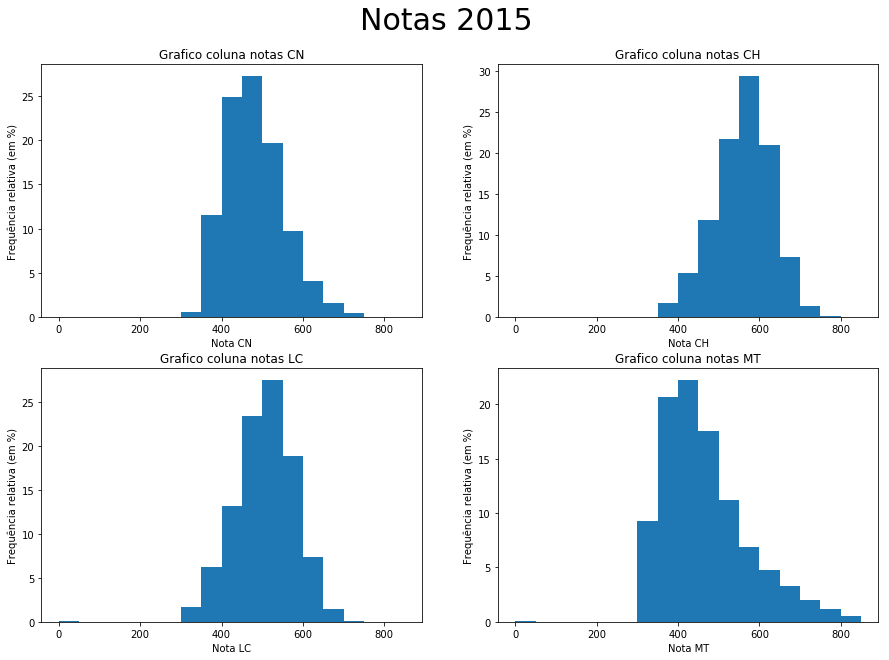

In [81]:
from numpy import zeros_like

fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plot = data_2015.NU_NOTA_CN.plot.hist(bins=faixa,title='Grafico coluna notas CN', weights=zeros_like(data_2015.NU_NOTA_CN)+1./data_2015.NU_NOTA_CN.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CN')

plt.subplot(222)
plot = data_2015.NU_NOTA_CH.plot.hist(bins=faixa,title='Grafico coluna notas CH', weights=zeros_like(data_2015.NU_NOTA_CH)+1./data_2015.NU_NOTA_CH.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CH')

plt.subplot(223)
plot = data_2015.NU_NOTA_LC.plot.hist(bins=faixa,title='Grafico coluna notas LC', weights=zeros_like(data_2015.NU_NOTA_LC)+1./data_2015.NU_NOTA_LC.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota LC')

plt.subplot(224)
plot = data_2015.NU_NOTA_MT.plot.hist(bins=faixa,title='Grafico coluna notas MT', weights=zeros_like(data_2015.NU_NOTA_MT)+1./data_2015.NU_NOTA_MT.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota MT')

plt.suptitle('Notas 2015', fontsize=30)
plt.subplots_adjust(top=0.9)
plt.show()

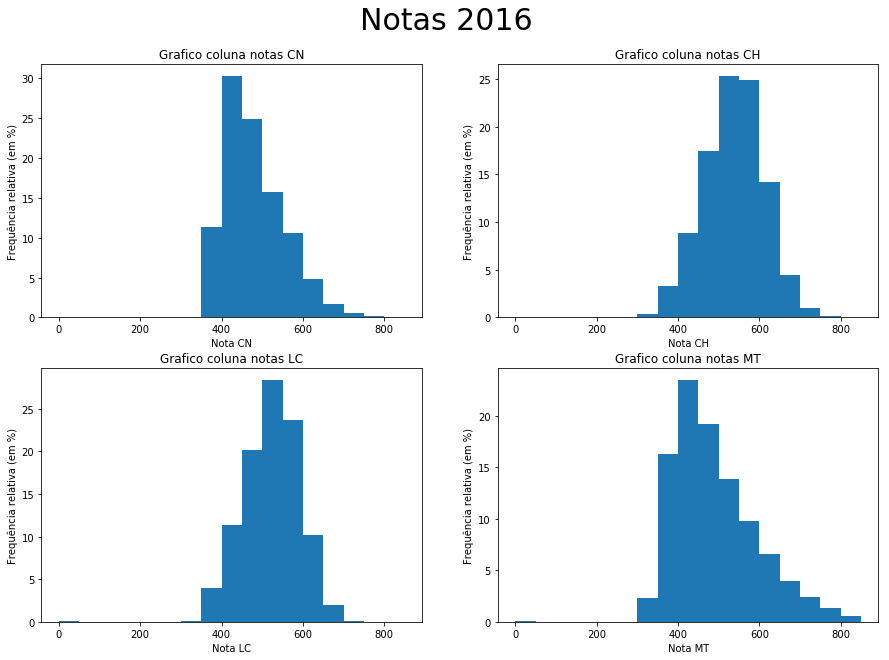

In [82]:
from numpy import zeros_like

fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plot = data_2016.NU_NOTA_CN.plot.hist(bins=faixa,title='Grafico coluna notas CN', weights=zeros_like(data_2016.NU_NOTA_CN)+1./data_2016.NU_NOTA_CN.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CN')

plt.subplot(222)
plot = data_2016.NU_NOTA_CH.plot.hist(bins=faixa,title='Grafico coluna notas CH', weights=zeros_like(data_2016.NU_NOTA_CH)+1./data_2016.NU_NOTA_CH.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CH')

plt.subplot(223)
plot = data_2016.NU_NOTA_LC.plot.hist(bins=faixa,title='Grafico coluna notas LC', weights=zeros_like(data_2016.NU_NOTA_LC)+1./data_2016.NU_NOTA_LC.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota LC')

plt.subplot(224)
plot = data_2016.NU_NOTA_MT.plot.hist(bins=faixa,title='Grafico coluna notas MT', weights=zeros_like(data_2016.NU_NOTA_MT)+1./data_2016.NU_NOTA_MT.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota MT')

plt.suptitle('Notas 2016', fontsize=30)
plt.subplots_adjust(top=0.9)
plt.show()

In [61]:
cn_renda = (pd.crosstab(data_2015.NU_NOTA_CN, data_2015.Q006 , margins=True, rownames=['NOTA CN'], colnames=['Renda'], normalize='index')*100).round(decimals=0)

In [74]:
cn_renda

Renda,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q
NOTA CN,,,,,,,,,,,,,,,,,
0.0,4.0,31.0,28.0,12.0,8.0,6.0,4.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
335.3,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335.7,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335.8,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336.4,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336.5,8.0,41.0,26.0,8.0,4.0,4.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
336.6,4.0,39.0,20.0,13.0,13.0,2.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
336.7,5.0,43.0,28.0,13.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
336.8,16.0,48.0,16.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
faixa_rendaC = data_2015[data_2015.Q006 == 'C']

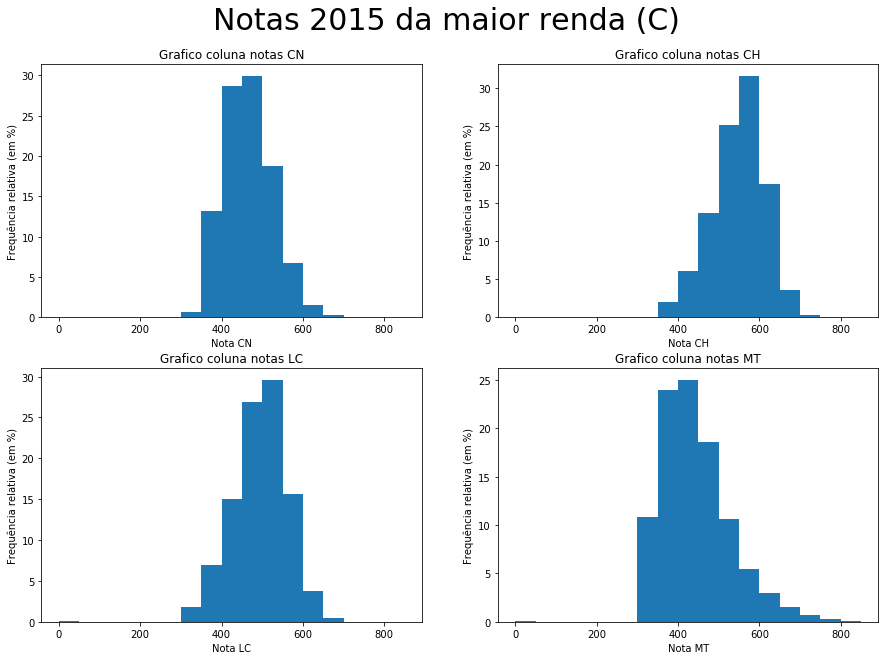

In [83]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plot = faixa_rendaC.NU_NOTA_CN.plot.hist(bins=faixa,title='Grafico coluna notas CN', weights=zeros_like(faixa_rendaC.NU_NOTA_CN)+1./faixa_rendaC.NU_NOTA_CN.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CN')

plt.subplot(222)
plot = faixa_rendaC.NU_NOTA_CH.plot.hist(bins=faixa,title='Grafico coluna notas CH', weights=zeros_like(faixa_rendaC.NU_NOTA_CH)+1./faixa_rendaC.NU_NOTA_CH.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CH')

plt.subplot(223)
plot = faixa_rendaC.NU_NOTA_LC.plot.hist(bins=faixa,title='Grafico coluna notas LC', weights=zeros_like(faixa_rendaC.NU_NOTA_LC)+1./faixa_rendaC.NU_NOTA_LC.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota LC')

plt.subplot(224)
plot = faixa_rendaC.NU_NOTA_MT.plot.hist(bins=faixa,title='Grafico coluna notas MT', weights=zeros_like(faixa_rendaC.NU_NOTA_MT)+1./faixa_rendaC.NU_NOTA_MT.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota MT')

plt.suptitle('Notas 2015 da maior renda (C)', fontsize=30)
plt.subplots_adjust(top=0.9)
plt.show()

In [87]:
data_2015.loc[(data_2015.SG_UF_RESIDENCIA=='RO') | (data_2015.SG_UF_RESIDENCIA=='AC') | (data_2015.SG_UF_RESIDENCIA=='AM') | (data_2015.SG_UF_RESIDENCIA=='RR') | (data_2015.SG_UF_RESIDENCIA=='PA') | (data_2015.SG_UF_RESIDENCIA=='AP') | (data_2015.SG_UF_RESIDENCIA=='TO'),'Regiao'] = 'Norte'
data_2015.loc[(data_2015.SG_UF_RESIDENCIA=='MA') | (data_2015.SG_UF_RESIDENCIA=='PI') | (data_2015.SG_UF_RESIDENCIA=='CE') | (data_2015.SG_UF_RESIDENCIA=='RN') | (data_2015.SG_UF_RESIDENCIA=='PB') | (data_2015.SG_UF_RESIDENCIA=='PE') | (data_2015.SG_UF_RESIDENCIA=='AL') | (data_2015.SG_UF_RESIDENCIA=='SE') | (data_2015.SG_UF_RESIDENCIA=='BH'),'Regiao'] = 'Nordeste'
data_2015.loc[(data_2015.SG_UF_RESIDENCIA=='MG') | (data_2015.SG_UF_RESIDENCIA=='ES') | (data_2015.SG_UF_RESIDENCIA=='RJ') | (data_2015.SG_UF_RESIDENCIA=='SP'),'Regiao'] = 'Sudeste'
data_2015.loc[(data_2015.SG_UF_RESIDENCIA=='PR') | (data_2015.SG_UF_RESIDENCIA=='SC') | (data_2015.SG_UF_RESIDENCIA=='RS'),'Regiao'] = 'Sul'
data_2015.loc[(data_2015.SG_UF_RESIDENCIA=='MS') | (data_2015.SG_UF_RESIDENCIA=='MT') | (data_2015.SG_UF_RESIDENCIA=='GO') | (data_2015.SG_UF_RESIDENCIA=='DF'),'Regiao'] = 'Centroeste'

In [93]:
data_norte = data_2015.loc[data_2015.Regiao == 'Norte']
data_nordeste = data_2015.loc[data_2015.Regiao == 'Nordeste']
data_centroeste = data_2015.loc[data_2015.Regiao == 'Centroeste']
data_sul = data_2015.loc[data_2015.Regiao == 'Sul']
data_suldeste = data_2015.loc[data_2015.Regiao == 'Sudeste']

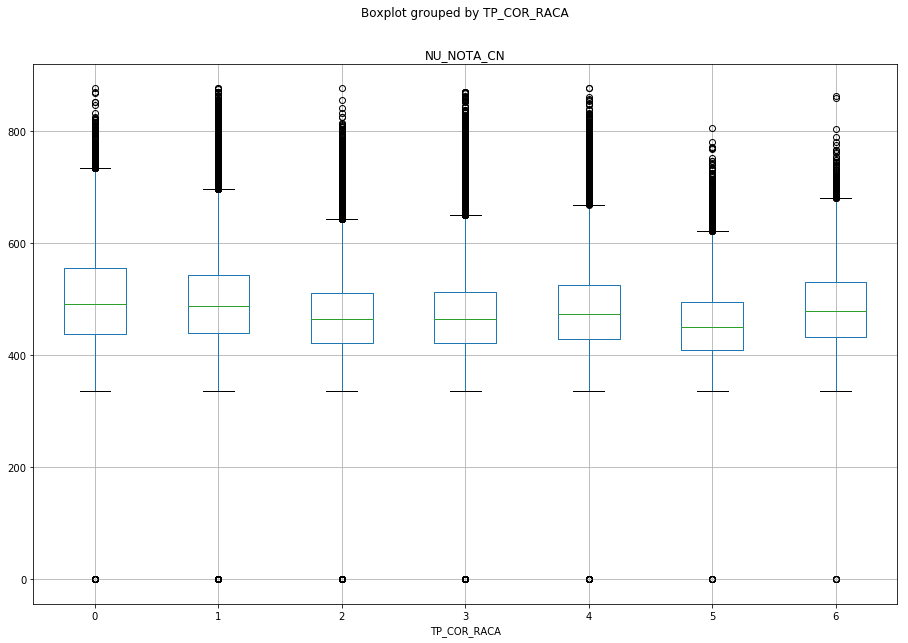

In [128]:
data_2015.boxplot(by='TP_COR_RACA', column=['NU_NOTA_CN'], grid=True, figsize=(15, 10))
plt.show()

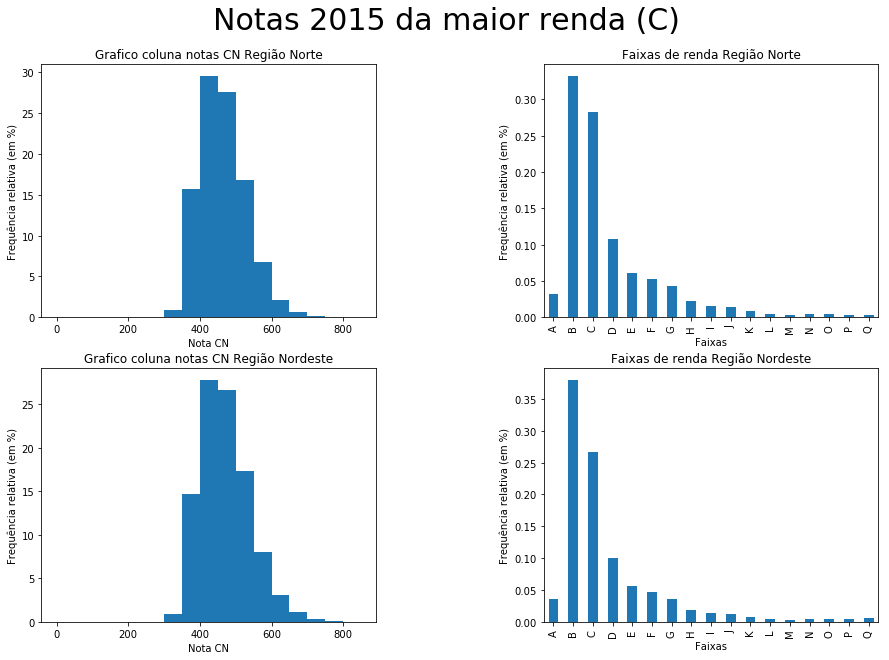

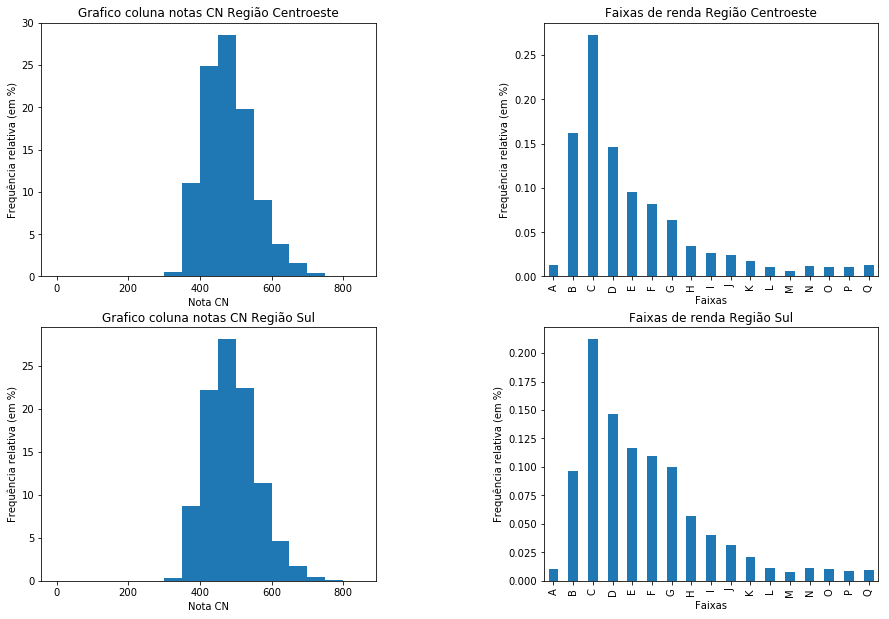

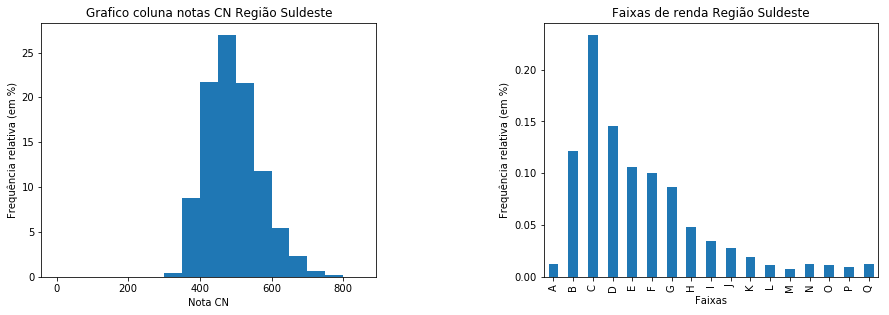

In [120]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(221)
data_norte.boxplot(by='Regiao', column=['NU_NOTA_CN'], grid=True)
plt.xlabel('Nota CN')

plt.subplot(222)
data_norte.Q006.value_counts(True).sort_index().plot(kind='bar', title='Faixas de renda Região Norte')
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Faixas')


plt.subplot(223)
data_norte.boxplot(by='Regiao', column=['NU_NOTA_CN'], grid=True)
plt.xlabel('Nota CN')

plt.subplot(224)
data_norte.boxplot(by='Regiao', column=['NU_NOTA_CN'], grid=True)
plt.xlabel('Faixas')

plt.suptitle('Notas 2015 da maior renda (C)', fontsize=30)
plt.subplots_adjust(top=0.9, wspace=0.5)
plt.show()

fig = plt.figure(figsize=(15, 10))

plt.subplot(221)
plot = data_centroeste.NU_NOTA_CN.plot.hist(bins=faixa,title='Grafico coluna notas CN Região Centroeste', weights=zeros_like(data_centroeste.NU_NOTA_CN)+1./data_centroeste.NU_NOTA_CN.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CN')

plt.subplot(222)
data_centroeste.Q006.value_counts(True).sort_index().plot(kind='bar', title='Faixas de renda Região Centroeste')
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Faixas')


plt.subplot(223)
plot = data_sul.NU_NOTA_CN.plot.hist(bins=faixa,title='Grafico coluna notas CN Região Sul', weights=zeros_like(data_sul.NU_NOTA_CN)+1./data_sul.NU_NOTA_CN.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CN')

plt.subplot(224)
data_sul.Q006.value_counts(True).sort_index().plot(kind='bar', title='Faixas de renda Região Sul')
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Faixas')


plt.subplots_adjust(top=0.9, wspace=0.5)
plt.show()

fig = plt.figure(figsize=(15, 10))


plt.subplot(221)
plot = data_suldeste.NU_NOTA_CN.plot.hist(bins=faixa,title='Grafico coluna notas CN Região Suldeste', weights=zeros_like(data_suldeste.NU_NOTA_CN)+1./data_suldeste.NU_NOTA_CN.size*100)
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Nota CN')

plt.subplot(222)
data_suldeste.Q006.value_counts(True).sort_index().plot(kind='bar', title='Faixas de renda Região Suldeste')
plt.ylabel('Frequência relativa (em %)')
plt.xlabel('Faixas')


plt.subplots_adjust(top=0.9, wspace=0.5)
plt.show()

## Bibliografia:

Sites consultados:
* https://openpyxl.readthedocs.io/en/2.5/pandas.html
* http://portal.inep.gov.br/microdados
* 
* 
* 
* 
* 
* 